## Diabetes Prediction using Diagnostic Features dataset

### Prediabetes Calculation and labelling
#### Based on HbA1c: 
A normal A1C level is below 5.7%, a level of 5.7% to 6.4% indicates prediabetes, and a level of 6.5% or more indicates diabetes. Within the 5.7% to 6.4% prediabetes range, the higher your A1C, the greater your risk is for developing type 2 diabetes.

https://www.cdc.gov/diabetes/managing/managing-blood-sugar/a1c.html#:~:text=A%20normal%20A1C%20level%20is,for%20developing%20type%202%20diabetes.

#### Based on Glucose level: 
Well, prediabetes means exactly what it sounds like: Your blood sugar levels are high, but not enough to diagnose diabetes. So, you may get diabetes in the future, although you don't have it right now. Doctors study your blood reports before declaring either diabetes or prediabetes based on where your fasting blood sugar count falls:

- Normal: Less than 100 mg/dL
- Prediabetic: 100–125 mg/dL
- Diabetic: Greater than 125 mg/dL

https://www.abbott.in/corpnewsroom/diabetes-care/prediabetic-diet--your-guide-to-blood-sugar-regulation.html#:~:text=Doctors%20study%20your%20blood%20reports,Greater%20than%20125%20mg%2FdL

Link for dataset: https://www.kaggle.com/houcembenmansour/predict-diabetes-based-on-diagnostic-measures

#### Features of dataset
- Cholesterol 	
- glucose 	
- hdl_chol 	
- chol_hdl_ratio 	
- age 	
- gender 	
- height 	
- weight 	
- bmi 	
- systolic_bp 	
- diastolic_bp 	
- waist 	
- hip 	
- waist_hip_ratio 	
- diabetes

Some links related to prediabetes
- https://www.mayoclinic.org/diseases-conditions/prediabetes/symptoms-causes/syc-20355278


- High levels of Tg in combination with low levels of HDL-C showed the strongest association with T2DM and prediabetes. This paper suggests that routine monitoring of the commonly used lipid parameters (especially Tg and HDL-C) among patients with T2DM and prediabetes, is warranted in this population considered to be the epi-center for T2DM or CAD.
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6165005/ .
Since 2004, the American Diabetes Association (ADA) has recommended screening of high-risk adults at any age for diabetes who have high BMI (≥25 kg/m2), low HDL-C (<0.90 mmol), and or a high Tg level (>2.82 mmol/L). 

- Total cholesterol, low density lipoprotein (LDL), triglyceride (TG), very low density lipoprotein, TG/HDL ratio and LDL/HDL ratio were significantly raised in prediabetic individuals as compared to normal healthy subjects, whereas high density lipoprotein (HDL) was significantly lower in prediabetic individuals as compared to normal healthy subjects.
https://pubmed.ncbi.nlm.nih.gov/27731552/
- https://www.imaware.health/blog/signs-of-prediabetes



<h3>Importing Libraries</h3>

In [1]:
#!pip install be-great

In [2]:
# Execute only once!
import os
import sys
sys.path.append("..")
os.chdir("..")

os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
import torch
torch.version.cuda

'11.3'

In [4]:
torch.cuda.is_available()

True

In [5]:
import logging
import pandas as pd
import numpy as np
from torch import nn
from torch import optim
from sklearn.preprocessing import StandardScaler
from functools import partial
from utils import set_logging_level
from be_great import GReaT

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [6]:
logger = set_logging_level(logging.INFO)

**Loading the Dataset**

In [7]:
#Reading the data and some data are not present as decimals
data=pd.read_csv("Predict diabetes based on diagnostic measures.csv",decimal=",")
df =data.copy()
pd.set_option('display.max_row',df.shape[0])
pd.set_option('display.max_column',df.shape[1]) 
df.head()

,patient_number,cholesterol,glucose,hdl_chol,chol_hdl_ratio,age,gender,height,weight,bmi,systolic_bp,diastolic_bp,waist,hip,waist_hip_ratio,diabetes
0,1,193,77,49,3.9,19,female,61,119,22.5,118,70,32,38,0.84,No diabetes
1,2,146,79,41,3.6,19,female,60,135,26.4,108,58,33,40,0.83,No diabetes
2,3,217,75,54,4.0,20,female,67,187,29.3,110,72,40,45,0.89,No diabetes
3,4,226,97,70,3.2,20,female,64,114,19.6,122,64,31,39,0.79,No diabetes
4,5,164,91,67,2.4,20,female,70,141,20.2,122,86,32,39,0.82,No diabetes


In [8]:
data.dtypes

patient_number       int64
cholesterol          int64
glucose              int64
hdl_chol             int64
chol_hdl_ratio     float64
age                  int64
gender              object
height               int64
weight               int64
bmi                float64
systolic_bp          int64
diastolic_bp         int64
waist                int64
hip                  int64
waist_hip_ratio    float64
diabetes            object
dtype: object

In [9]:
# Eliminate duplicates
print('There are' , df.duplicated().sum() , 'duplicates')
df.loc[df.duplicated(keep=False),:]
df.drop_duplicates(keep='first',inplace=True)
print('There is now' , df.shape[0] , 'rows')
print('There is now' , df.shape[1] , 'columns')

There are 0 duplicates
There is now 390 rows
There is now 16 columns


In [10]:
df.shape

(390, 16)

In [11]:
df_incorrect = df[(df['glucose'] <= 70) & (df['diabetes'] == 'Diabetes')]

In [12]:
df_incorrect

,patient_number,cholesterol,glucose,hdl_chol,chol_hdl_ratio,age,gender,height,weight,bmi,systolic_bp,diastolic_bp,waist,hip,waist_hip_ratio,diabetes
40,41,220,60,66,3.3,26,male,70,150,21.5,136,88,33,39,0.85,Diabetes


In [13]:
df_incorrect.replace('Diabetes','Diabetic')

,patient_number,cholesterol,glucose,hdl_chol,chol_hdl_ratio,age,gender,height,weight,bmi,systolic_bp,diastolic_bp,waist,hip,waist_hip_ratio,diabetes
40,41,220,60,66,3.3,26,male,70,150,21.5,136,88,33,39,0.85,Diabetic


In [14]:
df.drop(df[(df['glucose'] <= 70) & (df['diabetes'] == 'Diabetes')].index, inplace=True)

In [15]:
#checking if needed
#Changing incorrectly labelled data
#df[(df['glucose'] <= 70) & (df['diabetes'] == 'Diabetes')].replace('Diabetes','No diabetes')

In [16]:
df_incorrect_2 = df[(df['glucose'] <= 100) & (df['diabetes'] == 'Diabetes')]

In [17]:
df_incorrect_2.head(10)

,patient_number,cholesterol,glucose,hdl_chol,chol_hdl_ratio,age,gender,height,weight,bmi,systolic_bp,diastolic_bp,waist,hip,waist_hip_ratio,diabetes
299,300,203,90,51,4.0,60,female,59,123,24.8,130,72,36,41,0.88,Diabetes
326,327,249,90,28,8.9,64,male,68,183,27.8,138,80,44,41,1.07,Diabetes
361,362,207,71,41,5.0,72,male,70,180,25.8,138,88,39,40,0.98,Diabetes


In [18]:
df_incorrect_2.replace('Diabetes','Diabetic')

,patient_number,cholesterol,glucose,hdl_chol,chol_hdl_ratio,age,gender,height,weight,bmi,systolic_bp,diastolic_bp,waist,hip,waist_hip_ratio,diabetes
299,300,203,90,51,4.0,60,female,59,123,24.8,130,72,36,41,0.88,Diabetic
326,327,249,90,28,8.9,64,male,68,183,27.8,138,80,44,41,1.07,Diabetic
361,362,207,71,41,5.0,72,male,70,180,25.8,138,88,39,40,0.98,Diabetic


In [19]:
df.drop(df[(df['glucose'] <= 100) & (df['diabetes'] == 'Diabetes')].index, inplace=True)

In [20]:
df_incorrect_3 = df[(df['glucose'] > 100) & (df['glucose'] <= 125) & (df['diabetes'] == 'Diabetes')]
df_incorrect_3.shape

(13, 16)

In [21]:
df_incorrect_3.head(13)

,patient_number,cholesterol,glucose,hdl_chol,chol_hdl_ratio,age,gender,height,weight,bmi,systolic_bp,diastolic_bp,waist,hip,waist_hip_ratio,diabetes
117,118,245,119,26,9.4,36,male,66,179,28.9,150,92,37,42,0.88,Diabetes
212,213,245,120,39,6.3,47,female,63,156,27.6,142,102,35,39,0.90,Diabetes
240,241,215,110,36,6.0,51,female,67,282,44.2,142,78,52,59,0.88,Diabetes
250,251,196,120,67,2.9,52,female,62,147,26.9,144,94,34,42,0.81,Diabetes
287,288,195,108,46,4.2,59,female,67,172,26.9,150,102,38,43,0.88,Diabetes
288,289,219,112,73,3.0,59,male,66,170,27.4,146,92,37,40,0.93,Diabetes
310,311,235,109,59,4.0,62,female,63,290,51.4,175,80,55,62,0.89,Diabetes
321,322,215,119,44,3.9,63,female,63,158,28.0,160,68,34,42,0.81,Diabetes
339,340,246,104,62,4.0,66,female,66,189,30.5,200,94,45,46,0.98,Diabetes
344,345,254,121,39,6.5,67,male,68,167,25.4,161,118,36,39,0.92,Diabetes


In [22]:
df_incorrect_3.replace('Diabetes','Diabetic')

,patient_number,cholesterol,glucose,hdl_chol,chol_hdl_ratio,age,gender,height,weight,bmi,systolic_bp,diastolic_bp,waist,hip,waist_hip_ratio,diabetes
117,118,245,119,26,9.4,36,male,66,179,28.9,150,92,37,42,0.88,Diabetic
212,213,245,120,39,6.3,47,female,63,156,27.6,142,102,35,39,0.90,Diabetic
240,241,215,110,36,6.0,51,female,67,282,44.2,142,78,52,59,0.88,Diabetic
250,251,196,120,67,2.9,52,female,62,147,26.9,144,94,34,42,0.81,Diabetic
287,288,195,108,46,4.2,59,female,67,172,26.9,150,102,38,43,0.88,Diabetic
288,289,219,112,73,3.0,59,male,66,170,27.4,146,92,37,40,0.93,Diabetic
310,311,235,109,59,4.0,62,female,63,290,51.4,175,80,55,62,0.89,Diabetic
321,322,215,119,44,3.9,63,female,63,158,28.0,160,68,34,42,0.81,Diabetic
339,340,246,104,62,4.0,66,female,66,189,30.5,200,94,45,46,0.98,Diabetic
344,345,254,121,39,6.5,67,male,68,167,25.4,161,118,36,39,0.92,Diabetic


In [23]:
df.drop(df[(df['glucose'] > 100) & (df['glucose'] <= 125) & (df['diabetes'] == 'Diabetes')].index, inplace=True)

#### Data labelling!
- Glucose >125mg/dl is known as diabetes,
- Glucose 125mg/dl to 100mg/dl is prediabetes, while Glucose< 100mg/dl is for normal patients
- Some rows given are complex

In [24]:
df.shape

(373, 16)

In [25]:
df['diabetes'].value_counts(normalize=True)

No diabetes    0.884718
Diabetes       0.115282
Name: diabetes, dtype: float64

The abnormal rows are removed now, now the prediabetic case can be applied

In [26]:
df['diabetes'] = df['glucose'].apply(lambda x: 'Diabetic' if x > 125 else 'Prediabetic' if x > 100 and x <= 125 else 'Normal')
df.head()

,patient_number,cholesterol,glucose,hdl_chol,chol_hdl_ratio,age,gender,height,weight,bmi,systolic_bp,diastolic_bp,waist,hip,waist_hip_ratio,diabetes
0,1,193,77,49,3.9,19,female,61,119,22.5,118,70,32,38,0.84,Normal
1,2,146,79,41,3.6,19,female,60,135,26.4,108,58,33,40,0.83,Normal
2,3,217,75,54,4.0,20,female,67,187,29.3,110,72,40,45,0.89,Normal
3,4,226,97,70,3.2,20,female,64,114,19.6,122,64,31,39,0.79,Normal
4,5,164,91,67,2.4,20,female,70,141,20.2,122,86,32,39,0.82,Normal


In [27]:
df_all_rows = pd.concat([df, df_incorrect_3], ignore_index=True)

In [28]:
df_all_rows = pd.concat([df_all_rows, df_incorrect_2], ignore_index=True)

In [29]:
df_all_rows = pd.concat([df_all_rows, df_incorrect], ignore_index=True)

In [30]:
df_all_rows.shape

(390, 16)

In [31]:
df_all_rows.drop(['patient_number'],axis=1)

,cholesterol,glucose,hdl_chol,chol_hdl_ratio,age,gender,height,weight,bmi,systolic_bp,diastolic_bp,waist,hip,waist_hip_ratio,diabetes
0,193,77,49,3.9,19,female,61,119,22.5,118,70,32,38,0.84,Normal
1,146,79,41,3.6,19,female,60,135,26.4,108,58,33,40,0.83,Normal
2,217,75,54,4.0,20,female,67,187,29.3,110,72,40,45,0.89,Normal
3,226,97,70,3.2,20,female,64,114,19.6,122,64,31,39,0.79,Normal
4,164,91,67,2.4,20,female,70,141,20.2,122,86,32,39,0.82,Normal
5,170,69,64,2.7,20,female,64,161,27.6,108,70,37,40,0.93,Normal
6,149,77,49,3.0,20,female,62,115,21.0,105,82,31,37,0.84,Normal
7,164,71,63,2.6,20,male,72,145,19.7,108,78,29,36,0.81,Normal
8,230,112,64,3.6,20,male,67,159,24.9,100,90,31,39,0.79,Prediabetic
9,179,105,60,3.0,20,female,58,170,35.5,140,100,34,46,0.74,Prediabetic


#### Create GReaT Model

In [32]:
great = GReaT("distilgpt2",                  # Name of the large language model used (see HuggingFace for more options)
              epochs=100,                   # Number of epochs to train
              save_steps=2000,               # Save model weights every x steps
              #logging_steps=500,             # Log the loss and learning rate every x steps
              experiment_dir="trainer_diab", # Name of the directory where all intermediate steps are saved
              batch_size=16,                 # Batch Size
              #lr_scheduler_type="constant", # Specify the learning rate scheduler 
              #learning_rate=5e-5            # Set the inital learning rate
             )

#### Start Training

In [33]:
trainer = great.fit(df_all_rows)

2023-01-15 15:21:47,249 - INFO - Convert data into HuggingFace dataset object... (great.py:99)
2023-01-15 15:21:47,255 - INFO - Create GReaT Trainer... (great.py:104)
2023-01-15 15:21:47,446 - INFO - Start training... (great.py:113)
C:\Users\admin\anaconda3\envs\pytorch-gpu-diab\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 390
  Num Epochs = 100
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2500
  Number of trainable parameters = 81912576
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a me

Step,Training Loss
500,1.080800
1000,0.934600
1500,0.907800
2000,0.890300
2500,0.880400


Saving model checkpoint to trainer_diab\checkpoint-2000
Configuration saved in trainer_diab\checkpoint-2000\config.json
Model weights saved in trainer_diab\checkpoint-2000\pytorch_model.bin
tokenizer config file saved in trainer_diab\checkpoint-2000\tokenizer_config.json
Special tokens file saved in trainer_diab\checkpoint-2000\special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)




In [34]:
loss_hist = trainer.state.log_history.copy()
loss_hist.pop()

{'train_runtime': 296.8174,
 'train_samples_per_second': 131.394,
 'train_steps_per_second': 8.423,
 'total_flos': 982063423291392.0,
 'train_loss': 0.9387871337890625,
 'epoch': 100.0,
 'step': 2500}

In [35]:
loss = [x["loss"] for x in loss_hist]
epochs = [x["epoch"] for x in loss_hist]

In [36]:
loss = [x["loss"] for x in loss_hist]
epochs = [x["epoch"] for x in loss_hist]

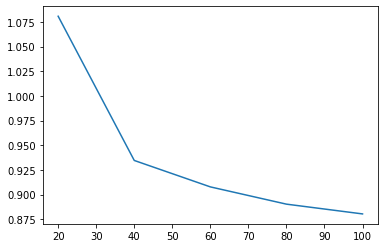

In [37]:
plt.plot(epochs, loss)

In [38]:
great.save("Diab_syn_100")

C:\Users\admin\anaconda3\envs\pytorch-gpu-diab\lib\site-packages\be_great\great.py:229: UserWarning: Directory Diab_syn_100 already exists and is overwritten now.
  warnings.warn(f"Directory {path} already exists and is overwritten now.")


#### Generate Samples

In [39]:
n_samples=10

In [40]:
samples = great.sample(n_samples)

76it [00:00, 80.52it/s]               


In [41]:
samples.head()

,patient_number,cholesterol,glucose,hdl_chol,chol_hdl_ratio,age,gender,height,weight,bmi,systolic_bp,diastolic_bp,waist,hip,waist_hip_ratio,diabetes
0,274.0,244.0,173.0,33.0,6.6,45.0,female,62.0,189.0,31.3,136.0,76.0,37.0,45.0,0.91,Diabetic
1,140.0,189.0,126.0,40.0,7.1,40.0,female,68.0,165.0,24.0,150.0,76.0,32.0,38.0,0.88,Diabetic
2,369.0,179.0,83.0,57.0,4.6,66.0,female,66.0,212.0,28.1,140.0,78.0,36.0,41.0,0.94,Normal
3,326.0,219.0,128.0,34.0,5.5,58.0,female,62.0,189.0,24.1,160.0,84.0,48.0,50.0,0.88,Diabetic
4,96.0,190.0,109.0,59.0,3.2,31.0,female,67.0,180.0,29.0,130.0,88.0,44.0,43.0,0.95,Prediabetic


In [42]:
samples.to_csv("diag_syn_great_100.csv")

In [45]:
samples.describe()

,patient_number,cholesterol,glucose,hdl_chol,chol_hdl_ratio,age,height,weight,bmi,systolic_bp,diastolic_bp,waist,hip,waist_hip_ratio
count,10.000000,10.000000,10.00000,10.000000,10.0000,10.000000,10.000000,10.0000,10.000000,10.000000,10.00000,10.000000,10.000000,10.000000
mean,204.100000,198.400000,113.00000,43.000000,5.2100,44.100000,64.300000,172.2000,26.920000,142.200000,80.20000,38.400000,41.600000,0.908000
std,109.647364,19.138095,28.37448,13.449494,1.2758,12.862089,2.451757,21.3375,4.225005,16.396477,9.25923,4.695151,3.747592,0.050067
min,20.000000,179.000000,76.00000,31.000000,3.2000,20.000000,62.000000,142.0000,22.000000,110.000000,62.00000,32.000000,37.000000,0.850000
25%,146.000000,188.250000,90.25000,34.000000,4.2250,40.250000,62.000000,160.5000,23.925000,133.000000,76.00000,36.000000,40.000000,0.865000
50%,178.000000,191.500000,113.50000,36.500000,5.2000,45.000000,63.500000,170.5000,26.100000,141.000000,81.00000,38.000000,40.500000,0.895000
75%,290.500000,198.000000,125.50000,52.750000,6.3250,48.750000,66.750000,186.7500,30.200000,157.500000,86.00000,39.000000,42.750000,0.947500
max,369.000000,244.000000,173.00000,69.000000,7.1000,66.000000,68.000000,212.0000,34.000000,162.000000,94.00000,48.000000,50.000000,1.000000


In [46]:
df_all_rows.describe()

,patient_number,cholesterol,glucose,hdl_chol,chol_hdl_ratio,age,height,weight,bmi,systolic_bp,diastolic_bp,waist,hip,waist_hip_ratio
count,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000
mean,195.500000,207.230769,107.338462,50.266667,4.524615,46.774359,65.951282,177.407692,28.775641,137.133333,83.289744,37.869231,42.992308,0.881385
std,112.727548,44.666005,53.798188,17.279069,1.736634,16.435911,3.918867,40.407824,6.600915,22.859528,13.498192,5.760947,5.664342,0.073212
min,1.000000,78.000000,48.000000,12.000000,1.500000,19.000000,52.000000,99.000000,15.200000,90.000000,48.000000,26.000000,30.000000,0.680000
25%,98.250000,179.000000,81.000000,38.000000,3.200000,34.000000,63.000000,150.250000,24.100000,122.000000,75.000000,33.000000,39.000000,0.830000
50%,195.500000,203.000000,90.000000,46.000000,4.200000,44.500000,66.000000,173.000000,27.800000,136.000000,82.000000,37.000000,42.000000,0.880000
75%,292.750000,229.000000,107.750000,59.000000,5.400000,60.000000,69.000000,200.000000,32.275000,148.000000,90.000000,41.000000,46.000000,0.930000
max,390.000000,443.000000,385.000000,120.000000,19.300000,92.000000,76.000000,325.000000,55.800000,250.000000,124.000000,56.000000,64.000000,1.140000


Check these links:
https://github.com/kathrinse/be_great/blob/main/examples/Example_Iris.ipynb

Citing

@article{borisov2022language,
  title={Language Models are Realistic Tabular Data Generators},
  author={Borisov, Vadim and Se{\ss}ler, Kathrin and Leemann, Tobias and Pawelczyk, Martin and Kasneci, Gjergji},
  journal={arXiv preprint arXiv:2210.06280},
  year={2022}
}